# Model Explicit Likelihood Inference
Infer from a cosmological model via MCMC samplers. 

In [4]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.66' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# !jupyter nbconvert --to script ./src/montecosmo/tests/model_ELI.ipynb

## Inference

### Import

In [6]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn
from montecosmo.models import print_config, get_prior_mean, default_config as config

# Build and render model
# config.update(a_lpt=0.5, mesh_size=8*np.ones(3, dtype=int))
config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int), fourier=True)
# config.update(a_lpt=0.1, mesh_size=64*np.ones(3, dtype=int), fourier=False)
model = partial(pmrsd_model, **config)
print_config(model)

# # Get fiducial parameters
# param_fn = get_param_fn(**config)
# fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_mean(model)))
# fiduc_params = get_simulator(fiduc_model)(rng_seed=0)

# # # Chain init
# @jit
# @vmap
# def sample_init_chains(rng_key, scale_std):
#     params_ = seed(prior_model, rng_key)(**config)
#     init_params = get_param_fn(scale_std=scale_std, **config)(**params_)
#     return get_param_fn(**config)(inverse=True, **init_params)

# init_params_ = sample_init_chains(jr.split(jr.key(1), 7), jnp.array([0]+6*[1/10]))
# init_params_ = tree_map(lambda x,y: jnp.concatenate((jnp.array(x)[None], y), axis=0), 
#                         get_param_fn(**config)(inverse=True, **fiduc_params), init_params_)
# pickle_dump(fiduc_params, save_dir+"fiduc_params_fourier.p")
# pickle_dump(init_params_, save_dir+"init_params_fourier_.p")

# Load fiducial and chain init params
fiduc_params = pickle_load(save_dir+"fiduc_params.p")
init_params_ = pickle_load(save_dir+"init_params_.p")
# fiduc_params = pickle_load(save_dir+"fiduc_params_pm.p")
# init_params_ = pickle_load(save_dir+"init_params_pm_.p")
# fiduc_params = pickle_load(save_dir+"fiduc_params_fourier.p")
# init_params_ = pickle_load(save_dir+"init_params_fourier_.p")

# Condition model on observables
obs_names = ['obs_mesh']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_model = condition(model, obs_params)
logp_fn = get_logp_fn(obs_model)
param_fn = get_param_fn(**config)
# print(fiduc_params, init_params_)

# CONFIG
{'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0]}, 'fourier': True, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [10.0, 10.0, 10.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.31416 h/Mpc
mean_gxy_density: 1.000 gxy/cell



In [7]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.0796027  -0.07960285  0.04843828 -0.21266134  0.05903318 -0.31464675
 -0.04204855 -0.06571629] 
 [ 0.913383    0.          0.0867136   0.09719938  0.23013133 -0.13022844
 -0.06570464  0.16659732]


In [ ]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.0796027  -0.07960285  0.04843828 -0.21266134  0.05903318 -0.31464675
 -0.04204855 -0.06571629] 
 [ 0.913383    0.          0.0867136   0.09719938  0.23013133 -0.13022844
 -0.06570464  0.16659732]


### Run

In [5]:
init_params_one_ = tree_map(lambda x: x[2], init_params_)
logp_fn(init_params_one_)

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

Array(-757824.5, dtype=float32)

### MCLMC

In [12]:
import blackjax

def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
    init_key, tune_key, run_key = jr.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
    )

    #####
    # find values for L and step_size
    (
        state_after_tuning,
        mclmc_sampler_params,
    ) = blackjax.adaptation.mclmc_adaptation.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
    )
    L = mclmc_sampler_params.L
    step_size = mclmc_sampler_params.step_size
    # init_state = state_after_tuning
    #####

    # L = 1/4
    # step_size = 1e-3
    init_state = initial_position

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=L,
        step_size=step_size,
    )

    # run the sampler
    last_state, samples, infos = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state_or_position=init_state,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return last_state, samples, infos, state_after_tuning, mclmc_sampler_params

In [ ]:
# # build the kernel
# kernel = blackjax.mcmc.mclmc.build_kernel(
#     logdensity_fn=logp_fn,
#     integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,)

# initial_state = blackjax.mcmc.mclmc.init(
#     position=init_params_one_, logdensity_fn=logp_fn, rng_key=jr.key(1))

# state_after_tuning, mclmc_sampler_params = blackjax.adaptation.mclmc_adaptation.mclmc_find_L_and_step_size(
#                                                 mclmc_kernel=kernel,
#                                                 num_steps=100,
#                                                 state=initial_state,
#                                                 rng_key=jr.key(0),)

In [13]:
last_state, samples, infos, state_after_tuning, mclmc_sampler_params = run_mclmc(
    logdensity_fn=logp_fn,
    num_steps=150,
    initial_position=init_params_one_,
    key=jr.key(0),
    transform=lambda x: x.position,
)

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [6]:
# pickle_dump(samples, save_dir+f"MCLMC_test1.p")

In [53]:
print(last_state, infos,  state_after_tuning, mclmc_sampler_params )

(IntegratorState(position={'Omega_m_': Array(-1.1007373, dtype=float32), 'b1_': Array(2.4938767, dtype=float32), 'b2_': Array(0.07510336, dtype=float32), 'bn2_': Array(-0.01747849, dtype=float32), 'bs2_': Array(0.00981485, dtype=float32), 'init_mesh_': Array([[[ 5.00958413e-03, -1.06019080e-01, -2.41102055e-01,
           3.56665015e-01, -2.25760818e-01, -3.55189264e-01,
           4.73863453e-01,  2.55167037e-01],
         [ 1.48404032e-01,  8.82291570e-02, -1.07138917e-01,
           2.55005620e-02,  5.49391694e-02, -2.45239332e-01,
          -6.12867437e-02,  8.05280134e-02],
         [ 8.27051625e-02,  1.31295189e-01, -1.12592272e-01,
          -2.83831626e-01, -1.28432930e-01,  9.23140645e-02,
           6.01872476e-03, -2.52374243e-02],
         [-2.12065101e-01,  1.50559813e-01,  3.71911214e-03,
           1.94160357e-01, -2.64290482e-01,  3.28156464e-02,
           1.20129719e-01, -9.82621461e-02],
         [ 7.96681195e-02,  1.37241244e-01,  1.68238193e-01,
           9.773519

In [11]:
post_samples_ = pickle_load(save_dir+f"MCLMC_test1.p")
post_samples_.pop('init_mesh_')
post_samples = vmap(get_param_fn(**config))(**post_samples_)

### HMCGibbs

In [52]:
import blackjax

def mwg_kernel_general(rng_key, state, logdensity_fn, step_fn, init, parameters):
    """
    General MWG kernel.

    Updates each component of ``state`` conditioned on all the others using a component-specific MCMC algorithm

    Parameters
    ----------
    rng_key
        The PRNG key.
    state
        Dictionary where each item is the state of an MCMC algorithm, i.e., an object of type ``AlgorithmState``.
    logdensity_fn
        The log-density function on all components, where the arguments are the keys of ``state``.
    step_fn
        Dictionary with the same keys as ``state``,
        each element of which is an MCMC stepping functions on the corresponding component.
    init
        Dictionary with the same keys as ``state``,
        each elemtn of chi is an MCMC initializer corresponding to the stepping functions in `step_fn`.
    parameters
        Dictionary with the same keys as ``state``, each of which is a dictionary of parameters to
        the MCMC algorithm for the corresponding component.

    Returns
    -------
    Dictionary containing the updated ``state``.
    """
    rng_keys = jr.split(rng_key, num=len(state))
    rng_keys = dict(zip(state.keys(), rng_keys))

    # avoid modifying argument state as JAX functions should be pure
    state = state.copy()

    for k in state.keys():
        # logdensity of component k conditioned on all other components in state
        def logdensity_k(value):
            union = {}
            for _k in state.keys():
                union |= state[_k].position
            union |= value # update component k
            return logdensity_fn(union) # **kwargs

        # give state[k] the right log_density
        state[k] = init[k](
            position=state[k].position,
            logdensity_fn=logdensity_k
        )

        # update state[k]
        state[k], _ = step_fn[k](
            rng_key=rng_keys[k],
            state=state[k],
            logdensity_fn=logdensity_k,
            **parameters[k]
        )

    return state


def sampling_loop_general(rng_key, initial_state, logdensity_fn, step_fn, init, parameters, num_samples):
    @jit
    def one_step(state, rng_key):
        state = mwg_kernel_general(
            rng_key=rng_key,
            state=state,
            logdensity_fn=logdensity_fn,
            step_fn=step_fn,
            init=init,
            parameters=parameters
        )
        positions = {k: state[k].position for k in state.keys()}
        return state, positions

    keys = jr.split(rng_key, num_samples)
    _, positions = lax.scan(one_step, initial_state, keys)

    return positions

In [8]:
warmup = blackjax.window_adaptation(blackjax.nuts, logp_fn)
rng_key, warmup_key, sample_key = jr.split(jr.key(0), 3)
(state, parameters), infos = warmup.run(warmup_key, init_params_one_, num_steps=10)

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [53]:
logdensity = logp_fn
init_poses = init_params_one_
init_pos_block1 = {name:init_poses[name] for name in ['init_mesh_']}
init_pos_block2 = {name:init_poses[name] for name in ['Omega_m_','sigma8_','b1_','b2_','bs2_','bn2_']}

# MCMC initializers for each set of paramters
mwg_init_x = blackjax.hmc.init
mwg_init_y = blackjax.hmc.init

# MCMC updaters
mwg_step_fn_x = blackjax.hmc.build_kernel()
mwg_step_fn_y = blackjax.hmc.build_kernel()  # default integrator, etc.

init_state = {
    "init_mesh_": mwg_init_x(
        position = init_pos_block1,
        logdensity_fn = lambda x: logdensity(x |init_pos_block2)
    ),
    "rest_": mwg_init_y(
        position = init_pos_block2,
        logdensity_fn = lambda y: logdensity(y | init_pos_block1)
    )
}

parameters = {
    "init_mesh_": {
        "inverse_mass_matrix": jnp.ones(64**3),
        "num_integration_steps": 10,
        "step_size": 1e-3
    },
    "rest_": {
        "inverse_mass_matrix": jnp.ones(6),
        "num_integration_steps": 10,
        "step_size": 1e-3
    }
}

In [56]:
block_samples_ = sampling_loop_general(
    rng_key = jr.key(42),
    initial_state = init_state,
    logdensity_fn = logdensity,
    step_fn={
        "init_mesh_": mwg_step_fn_x,
        "rest_": mwg_step_fn_y
    },
    init={
        "init_mesh_": mwg_init_x,
        "rest_": mwg_init_y
    },
    parameters = parameters,
    num_samples = 10
)

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [65]:
post_samples_ = {}
for block in block_samples_:
    post_samples_ |= block_samples_[block]
post_samples_.pop('init_mesh_')
post_samples = vmap(get_param_fn(**config))(**post_samples_)
post_samples

{'Omega_m': Array([0.31037465, 0.31120577, 0.3071187 , 0.30578333, 0.30312654,
        0.30085507, 0.2994535 , 0.30047357, 0.29977053, 0.3001732 ],      dtype=float32),
 'b1': Array([0.9959807, 0.9979266, 1.0093392, 1.0134159, 1.0124985, 1.0103701,
        1.005029 , 1.0105164, 1.0072465, 1.0187495], dtype=float32),
 'b2': Array([ 0.0070735 ,  0.02086339, -0.00388451, -0.02197985,  0.00065329,
        -0.01544637, -0.00495183, -0.00977663, -0.02196525, -0.04835448],      dtype=float32),
 'bn2': Array([-0.0203678 , -0.0584042 , -0.07246741, -0.07634399, -0.08095203,
        -0.11328842, -0.06086355, -0.05336163, -0.04426713, -0.04033747],      dtype=float32),
 'bs2': Array([-0.01516362,  0.03183125,  0.0210821 ,  0.02150009,  0.02036448,
        -0.01165057, -0.01495671, -0.02554469, -0.00744785,  0.00467549],      dtype=float32),
 'sigma8': Array([0.8085286 , 0.8085337 , 0.8085046 , 0.80742896, 0.8083309 ,
        0.807681  , 0.8100788 , 0.8116765 , 0.8161145 , 0.8170838 ],      dtype=

### NUTS, HMC

In [8]:
num_samples, max_tree_depth, n_runs, num_chains = 256, 10, 20, 8
# num_samples, max_tree_depth, n_runs, num_chains = 128, 10, 10, 4
# num_samples, max_tree_depth, n_runs, num_chains = 128, 10, 5, 4
# num_samples, max_tree_depth, n_runs, num_chains = 128, 10, 5, 1

# Variables to save
extra_fields = ['num_steps'] # e.g. 'num_steps'
# save_path = save_dir + f"HMC_ns{num_samples:d}_x_nc{num_chains}_2"
save_path = save_dir + f"NUTS_ns{num_samples:d}_x_nc{num_chains}_pm"
# save_path = save_dir + f"HMC_ns{num_samples:d}_test12"
# save_path = save_dir + f"NUTS_ns{num_samples:d}_test_fourier"

nuts_kernel = numpyro.infer.NUTS(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=True,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # XXX: dense matrix for cosmo params joint, diagonal for the rest
    step_size=1e-4, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,)

hmc_kernel = numpyro.infer.HMC(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    adapt_mass_matrix=True,
    step_size=1e-3, 
    adapt_step_size=True,
    trajectory_length= 1023 * 3*1e-3 / 4, # (2**max_tree_depth-1)*step_size_NUTS/(2 to 4), compare with default 2pi.
    )

# # Propose MALA step size based on [Chen+2019](http://arxiv.org/abs/1801.02309)
# L_smoothness, m_strong_convex = 1, 1 # log density regularity properties
# condition_number = L_smoothness / m_strong_convex
# print(f"MALA step size proposal={1 / (L_smoothness * (config['mesh_size'].prod() * condition_number)**0.5):e}")

# from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA
# mala_kernel = MALA(model=obs_model,
#                     init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
#                     step_size=0.001,)

mcmc = numpyro.infer.MCMC(
    sampler=nuts_kernel,
    # num_warmup=0,
    num_warmup=num_samples,
    num_samples=num_samples, # for each run
    num_chains=num_chains,
    chain_method="vectorized",
    progress_bar=True,)

# last_state = pickle_load(save_dir+"HMC_ns256_x_nc8"+"_laststate.p")
# print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
# mcmc.post_warmup_state = last_state

In [16]:
# mlflow.end_run()
# mlflow.start_run(run_name="HMC, ss=1e-3")
# mlflow.log_params(config)
# mlflow.log_params({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})
print({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})
print(save_path)

{'n_runs': 10, 'num_samples': 128, 'max_tree_depth': 10, 'num_chains': 4}
/feynman/home/dphp//hs276503/scratch/pickles/HMC_ns128_test12


In [48]:
# init_params_one_ = tree_map(lambda x: x[:num_chains], init_params_)
# mlflow.log_metric('halt',0) # 31.46s/it 4chains, 37.59s/it 8chains
# mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_one_)
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_)
# mlflow.log_metric('halt',1)

run 0/4 (warmup)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

KeyboardInterrupt: 

## Analysis

In [12]:
start_run, end_run = 0,0
var_names = [name+'_' for name in config['prior_config']] + ['num_steps']
# var_names = None

post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1,0], verbose=True)
# post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1], verbose=True)
# mlflow.log_params({'n_samples':n_samples, 'n_evals':n_evals})
# post_samples = [param_vfn(**s) for s in post_samples_]
post_samples = param_fn(**post_samples_)

loading: NUTS_ns128_test_fourier
total n_samples: (128,), total n_evals: 85559


In [49]:
post_samples_ = tree_map(lambda x: x[1], post_samples_)
post_samples = tree_map(lambda x: x[1], post_samples)

### Chain

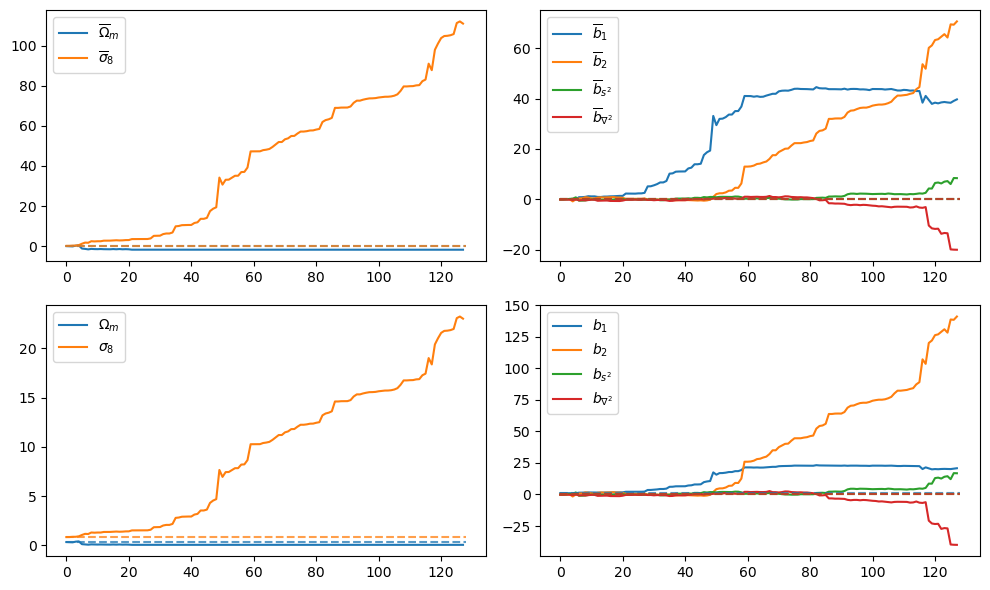

In [13]:
%matplotlib inline
def _plot_chain(samples:dict, prior_config:dict, fiduc:dict, **config):
    labels = []
    for name in samples:
        if name.endswith('_'): # convention for a latent value 
            lab = "\\overline"+prior_config[name[:-1]][0]
        else:
            lab = prior_config[name][0]
        labels.append('$'+lab+'$')

    samples_arr = np.array(list((samples.values()))).T

    plt.plot(samples_arr, label=labels)
    plt.hlines([fiduc[name] for name in samples], 
            xmin=0, xmax=len(samples_arr), 
            ls="--", alpha=0.75,
            color=[f"C{i}" for i in range(len(samples))],)
# slice_toplot = np.concatenate([range(i,i+10) for i in [0,5*60-5, 6*60-5]])

def plot_chain(samples_:dict, prior_config:dict, fiduc:dict, **config):
    samples = get_param_fn(prior_config=prior_config, **config)(**samples_)
    plot_fn = partial(_plot_chain, prior_config=prior_config, fiduc=fiduc)

    plt.figure(figsize=(10,6))
    plt.subplot(221)
    plot_fn({name:samples_[name] for name in ['Omega_m_','sigma8_']})
    plt.legend(), 
    plt.subplot(222)
    plot_fn({name:samples_[name] for name in ['b1_','b2_','bs2_','bn2_']})
    plt.legend(), 
    plt.subplot(223)
    plot_fn({name:samples[name] for name in ['Omega_m','sigma8']})
    plt.legend(), 
    plt.subplot(224)
    plot_fn({name:samples[name] for name in ['b1', 'b2','bs2','bn2']})
    plt.legend(), 
    plt.tight_layout()
    # mlflow.log_figure(plt.gcf(), f"HMC_chain_L1o2_neval1102004.svg")
    plt.show();

# plot_chain(post_samples_[1], fiduc=fiduc_params, **config)
plot_chain(post_samples_, fiduc=fiduc_params, **config)

### Contours

In [40]:
from numpyro.diagnostics import effective_sample_size, gelman_rubin

def get_metric_traj(metric_fn, samples, num, num_steps=None):
    def _get_metric_traj(samples):
        metrics = []
        length = len(samples[0])
        for i_filt in np.arange(length, 1, -length// num)[::-1]:

            if num_steps is not None:
                metrics.append([num_steps[:,:i_filt].sum(), metric_fn(samples[:,:i_filt])])
            else:
                metrics.append(metric_fn(samples[:,:i_filt]))
        return jnp.array(metrics).T
    return tree_map(_get_metric_traj, samples)

n_toplot = 300
ESSs = get_metric_traj(effective_sample_size, post_samples, n_toplot, post_samples_['num_steps'])
GRs = get_metric_traj(gelman_rubin, post_samples, n_toplot, post_samples_['num_steps'])

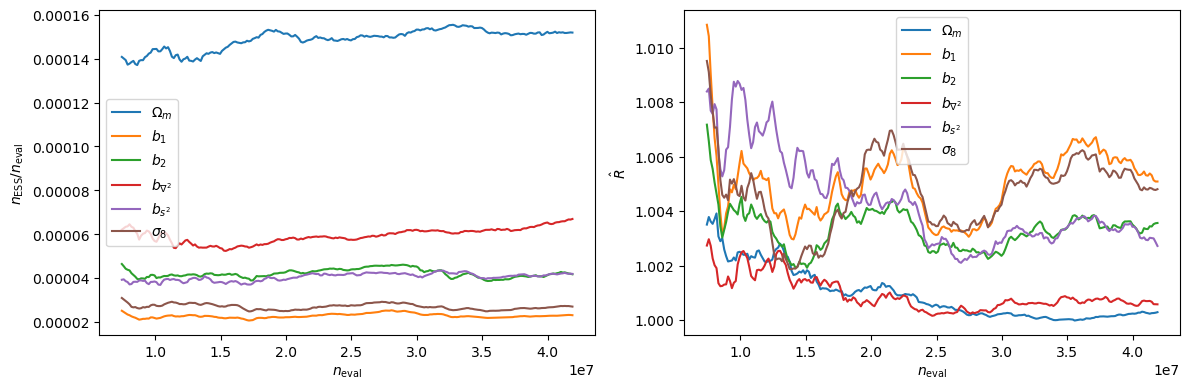

In [46]:
plt.figure(figsize=(12,4))
plt.subplot(121)
i_tostart = 50
plot_fn = lambda x, **kwargs: plt.plot(x[0], x[1]/x[0], **kwargs)
for name, val in ESSs.items():
    plot_fn(val[:,i_tostart:], label='$'+config['prior_config'][name][0]+'$')
plt.xlabel("$n_{\\text{eval}}$"), plt.ylabel("$n_{\\text{ESS}}/n_{\\text{eval}}$")
plt.legend()

plt.subplot(122)
plot_fn = lambda x, **kwargs: plt.plot(*x, **kwargs)
for name, val in GRs.items():
    plot_fn(val[:,i_tostart:], label='$'+config['prior_config'][name][0]+'$')
plt.xlabel("$n_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
plt.legend()
plt.tight_layout()
plt.show();

In [44]:
paths = ["NUTS_ns256_x_nc8","HMC_ns256_x_nc8"]
mc_labels = ["NUTS","HMC"]
start_run, end_run = [2,2], [20,20]

load_paths = np.array([os.path.join(save_dir, path) for path in paths])
var_names = [name+'_' for name in config['prior_config']] + ['num_steps']

# post_samples_ = load_runs(load_paths, start_run, end_run, var_names, conc_axis=[1,0], verbose=True)
post_samples_ = load_runs(load_paths, start_run, end_run, var_names, conc_axis=[1], verbose=True)

post_samples = [param_fn(**s) for s in post_samples_]

loading: NUTS_ns256_x_nc8
total n_samples: (8, 4864), total n_evals: [4975872 4975872 4975872 4975872 4975872 4975872 4975872 4975872]
loading: HMC_ns256_x_nc8
total n_samples: (8, 4864), total n_evals: [ 997120 1186816 1216000 1211136 1186816 1128448  880384  817152]


In [45]:
from numpyro.diagnostics import print_summary
for sample in post_samples:
    print_summary(sample, group_by_chain=True) # NOTE: group_by_chain if several chains


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.31      0.01      0.30      0.29      0.32   6033.79      1.00
    sigma8      0.81      0.01      0.81      0.79      0.83   1085.30      1.01
        b1      0.98      0.03      0.98      0.92      1.03    932.22      1.01
        b2     -0.03      0.01     -0.03     -0.06     -0.01   1727.42      1.01
       bs2      0.02      0.05      0.02     -0.07      0.10   1720.29      1.01
       bn2     -0.61      0.36     -0.61     -1.20     -0.03   2679.37      1.00


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.29      0.32   1200.08      1.01
    sigma8      0.81      0.01      0.81      0.79      0.83    383.21      1.01
        b1      0.97      0.03      0.97      0.92      1.02    273.38      1.02
        b2     -0.03      0.01     -0.03     -0.06     -0.01    489.73      1.01
       bs2      0.01     

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_310369/4003622246.py:6: SyntaxWarning: invalid escape sequence '\s'
  gdsamples[i_gds] = gds.copy(label=mc_labels[i_gds]+", 1$\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})


Removed no burn in
# NUTS
using 38912 rows, 6 parameters; mean weight 1.0, tot weight 38912.0
Equiv number of single samples (sum w)/max(w): 38912
Effective number of weighted samples (sum w)^2/sum(w^2): 38912


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.31      0.01      0.30      0.29      0.32   6026.95      1.00
        b1      0.98      0.03      0.98      0.92      1.03    949.14      1.00
        b2     -0.03      0.01     -0.03     -0.06     -0.01   1731.21      1.00
       bn2     -0.61      0.36     -0.61     -1.20     -0.03   2665.91      1.00
       bs2      0.02      0.05      0.02     -0.07      0.10   1757.04      1.00
    sigma8      0.81      0.01      0.81      0.79      0.83   1114.22      1.00

Removed no burn in
# HMC
using 38912 rows, 6 parameters; mean weight 1.0, tot weight 38912.0
Equiv number of single samples (sum w)/max(w): 38912
Effective number of weighted samples (sum w)^2/sum(w^2): 38912


         

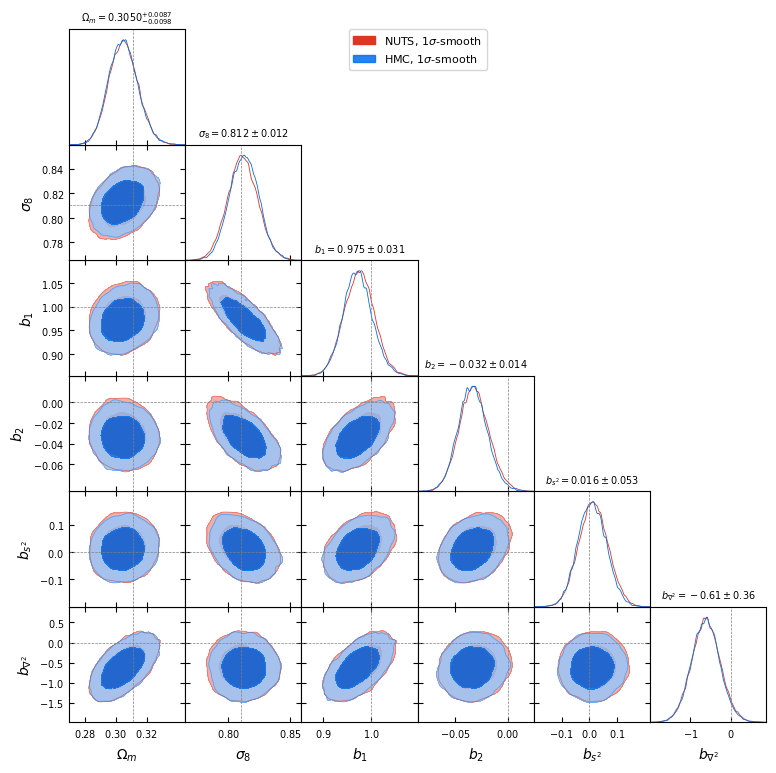

In [42]:
%matplotlib inline
from montecosmo.utils import get_gdsamples, get_gdprior

gdsamples = get_gdsamples(post_samples, label=mc_labels, verbose=True, **config)
for i_gds, gds in enumerate(gdsamples):
    gdsamples[i_gds] = gds.copy(label=mc_labels[i_gds]+", 1$\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})

# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))
g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r's
g.triangle_plot(roots=gdsamples , 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
# plt.savefig('NUTS_mtd10_8192_unstandard_short.svg', bbox_inches='tight')
plt.show();

Removed no burn in
Removed no burn in
Removed no burn in


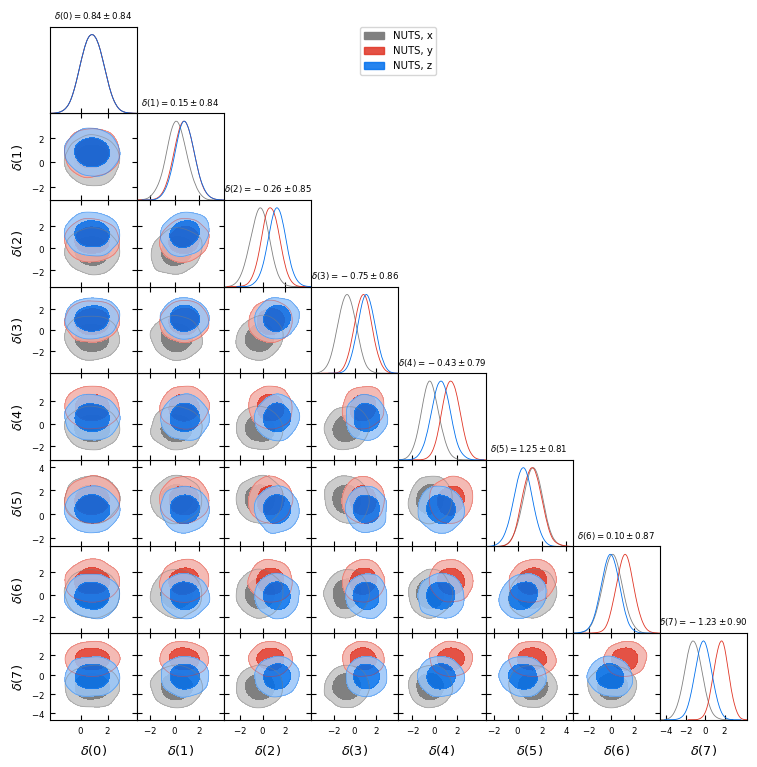

In [8]:
from getdist import MCSamples

def get_gdsamples_mesh(samples:dict, fiduc:dict, n:int, stop:int=None, axis:int=0, label:str=None):
    mesh_samples = samples['init_mesh']
    mesh_fiduc = fiduc['init_mesh']

    subsamples = {}
    subfiduc = {}
    labels = []
    slices0 = len(mesh_fiduc.shape)*[slice(0,1)]
    name0 = len(mesh_fiduc.shape) * ["0"]
    if stop is None:
        stop = mesh_fiduc.shape[axis]
    for i in np.linspace(0, stop, n, endpoint=False, dtype=int):
        slices, name = slices0.copy(), name0.copy()
        slices[axis] = slice(i,i+1)
        # name[axis] = str(i)
        # name = "delta("+",".join(name)+")"
        # lab = "\\"+name
        name = f"delta({i})"
        lab = "\\"+name

        subsamples[name] = mesh_samples[:,*slices].squeeze()
        subfiduc[name] = mesh_fiduc[*slices].squeeze()
        labels.append(lab)
 
    gdsamples = MCSamples(samples=list(subsamples.values()), names=list(subsamples.keys()), labels=labels, label=label)
    return gdsamples, subfiduc

ntoplot = 8
stop = 8
gdsamplesX, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=0, label="NUTS, x")
gdsamplesY, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=1, label="NUTS, y")
gdsamplesZ, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=2, label="NUTS, z")

g.triangle_plot(roots=[gdsamplesX, gdsamplesY, gdsamplesZ] , 
                title_limit=1, 
                filled=True, 
                # markers=subfiduc,
                )
# plt.savefig('NUTS_mtd10_1560_meshtriangle.svg', dpi=200, bbox_inches='tight')
plt.show();

### Spectrum distribution

In [9]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
pk_fiduc = pk_fn(fiduc_params['init_mesh'])
pk_post = vmap(pk_fn)(post_samples['init_mesh'])
qs = jnp.array([0.0015, 0.0250, 0.1600, 0.5, 0.840, 0.9750, 0.9985])
pk_0015, pk_0250, pk_1600, pk_5000, pk_8400, pk_9750, pk_9985 = jnp.quantile(pk_post, q=qs, axis=0)

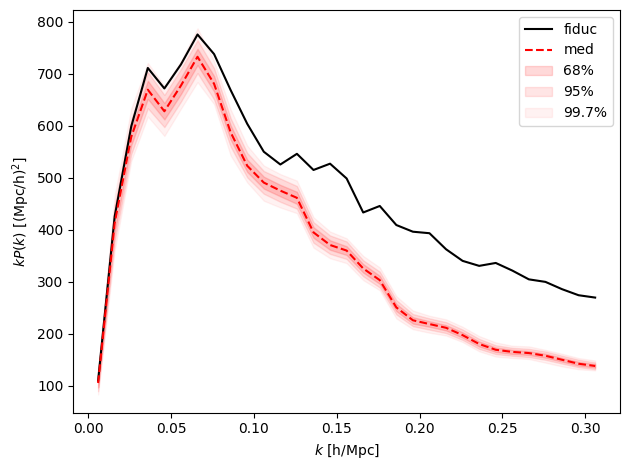

In [10]:
plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)
plotfill_fn = lambda pklow, pkup, *args, **kwargs: plt.fill_between(pklow[0], pklow[0]*pklow[1], pklow[0]*pkup[1], *args, **kwargs)

plot_fn(pk_fiduc, 'k', label='fiduc')
plot_fn(pk_5000, 'r--', label='med')
plotfill_fn(pk_1600, pk_8400, alpha=0.15, color='red', label='68%')
plotfill_fn(pk_0250, pk_9750, alpha=0.10, color='red', label='95%')
plotfill_fn(pk_0015, pk_9985, alpha=0.05, color='red', label='99.7%')
plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P(k)$ [(Mpc/h)$^2$]")
plt.legend()
plt.tight_layout()
# plt.savefig('post_pk.svg', dpi=200, bbox_inches='tight')
plt.show()

### Mass matrix

In [132]:
# Load mass matrix
import pickle
with open(save_path+f"_laststate16.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

0.0036300123 {('Omega_c_', 'b1_', 'b2_', 'bnl_', 'bs_', 'init_mesh_', 'sigma8_'): Array([6.1043068e-03, 1.6954450e-03, 7.9886860e-04, ..., 8.5615098e-01,
       6.2965083e-01, 3.9922595e-03], dtype=float32)}


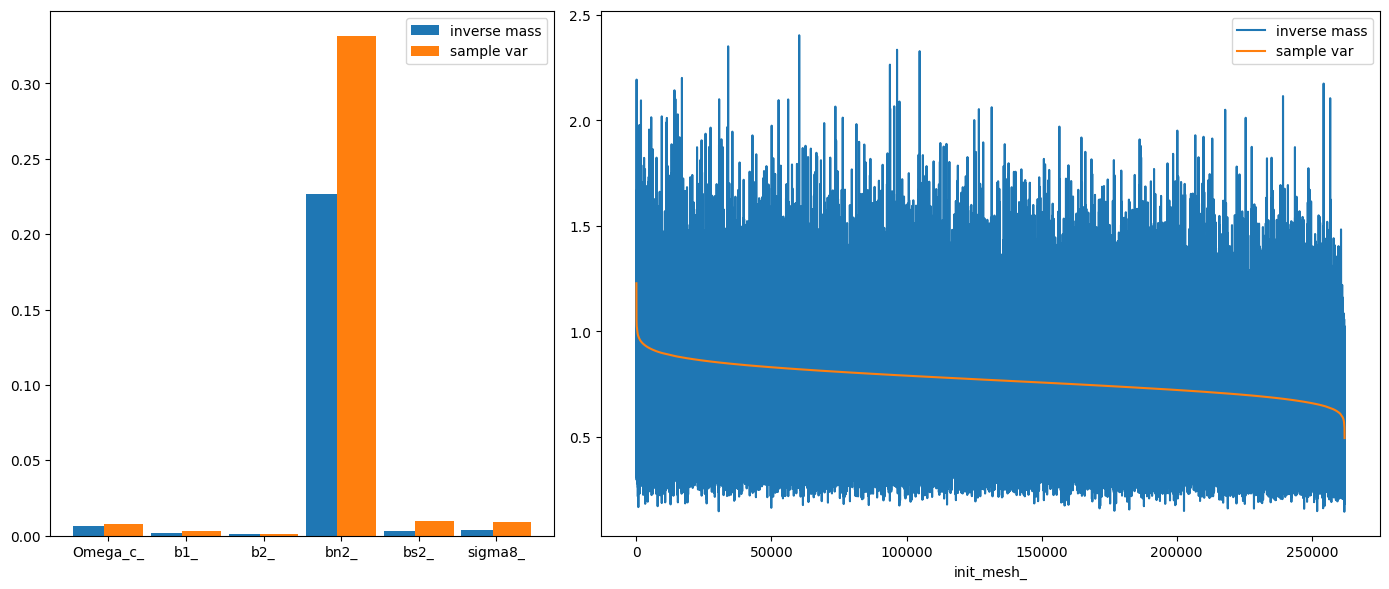

In [143]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    if var_name == 'bnl_':
        var_name = 'bn2_'
    if var_name == 'bs_':
        var_name = 'bs2_'
    var_variance = post_samples_[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,6))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_")
plt.legend(), plt.tight_layout()
plt.savefig(save_path+"_invMvar.svg");

In [ ]:
# # Save posterior variance as inverse mass matrix format
# post_variance = []
# for var_name in var_names:
#     if var_name == 'init_mesh_base':
#         var_name = 'init_mesh'
#         post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
#     else:
#         post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
#         post_variance = np.concatenate((post_variance, ))
# variance_as_invM = {var_names: post_variance}
# print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

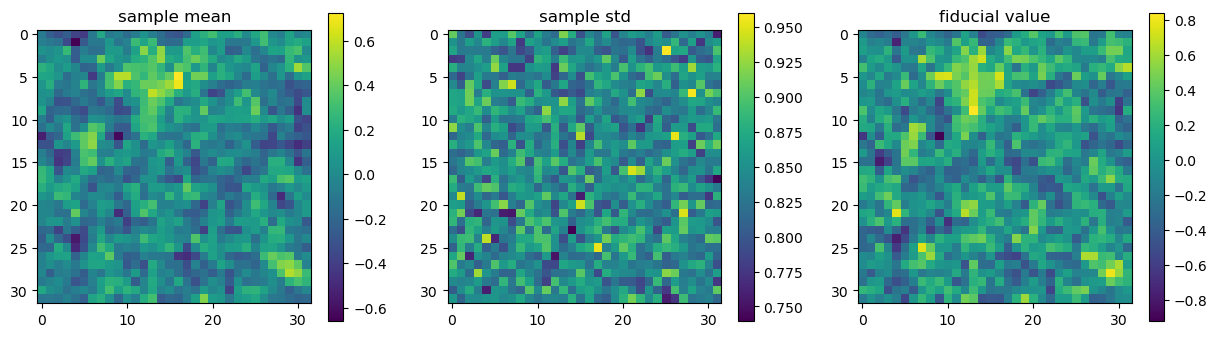

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();